**Проект: вариант 3 - дейтинговое приложение.**

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

**Основная цель** - проверить был ли эксперимент успешен в целом.

**Список задач:**

* Проверка корректности и баланса групп
* Очистка и обогащение данных
* Формирование и расчёт метрик
* Статистическая проверка гипотез
* Сегментный анализ и интерпретация


**Описание данных:**

Файлы:
* `users_test` – информация о пользователях в тестовой группе. 
* `users_control_1` – информация о пользователях в первой контрольной группе. 
* `users_control_2` – информация о пользователях во второй контрольной группе.
* `transactions_test` – информация о платежах пользователей в тестовой группе. 
* `transactions_control_1` – информация о платежах пользователей в первой контрольной группе.
* `transactions_control_2` – информация о платежах пользователей во второй контрольной группе


Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). 

Для каждой из них:

**`users_*.csv`** – информация о пользователях:

* `uid` – идентификатор пользователя
* `age` – возраст
* `attraction_coeff` – коэффициент привлекательности (от 0 до 1000,$\frac{\text{просмотры}}{\text{лайки}} \cdot 1000$)
* `coins` – число монеток (внутренняя валюта)
* `country` – страна  
* `visit_days` – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
* `gender` – пол
* `age_filter_start`  – фильтр поиска, мин. значение 
* `age_filter_end`  – фильтр поиска, макс. значение 
* `views_count` – число полученных оценок 
* `was_premium` – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
* `is_premium` –  является ли премиум
* `total_revenue` – нормированная выручка 


**`transactions_*.csv`** – информация о платежах пользователей:

* `uid` – идентификатор пользователя
* `country` – страна
* `joined_at` – дата и время регистрации
* `paid_at` – дата и время покупки
* `revenue` – нормированная выручка
* `payment_id` – идентификатор платежа
* `from_page` – откуда пользователь перешел на страницу оплаты
* `product_type` – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

 

### 1. Загрузка данных и первичный анализ 

#### 1.1 Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.stats as st
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from datetime import timedelta
from typing import List, Tuple
from statsmodels.stats.multitest import multipletests
sns.set_style('whitegrid')

In [2]:
ALPHA       = 0.05                    # уровень значимости
POWER_TGT   = 0.80                    # желаемая мощность
PREMIUM_TPS = ['trial_premium', 'premium_no_trial']
BOOTSTRAP_SAMPLES = 10_000            # итерации бутстрапа
RNG = np.random.default_rng(seed=42)  # воспроизводимость

In [3]:
trans_c1 = pd.read_csv('Проект_3_transactions_control_1.csv', sep = ';')
trans_c2 = pd.read_csv('Проект_3_transactions_control_2.csv', sep = ';')
trans_t = pd.read_csv('Проект_3_transactions_test.csv', sep = ';')
users_c1 = pd.read_csv('Проект_3_users_control_1.csv', sep = ';')
users_c2 = pd.read_csv('Проект_3_users_control_2.csv', sep = ';')
users_t =  pd.read_csv('Проект_3_users_test.csv', sep = ';')

#### 1.2 Первичный осмотр данных 

In [4]:
trans_c1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [5]:
trans_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           377 non-null    float64
 1   country       377 non-null    object 
 2   joined_at     1007 non-null   object 
 3   paid_at       1007 non-null   object 
 4   revenue       377 non-null    float64
 5   payment_id    377 non-null    float64
 6   from_page     377 non-null    object 
 7   product_type  377 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.1+ KB


In [6]:
trans_c1.describe()

,uid,revenue,payment_id
count,3.770000e+02,377.000000,377.000000
mean,8.923612e+08,6929.206897,91.145889
std,6.162900e+06,8027.889630,58.599773
min,8.910923e+08,26.000000,0.000000
25%,8.913833e+08,2730.000000,19.000000
50%,8.918225e+08,6266.000000,127.000000
75%,8.921850e+08,6448.000000,147.000000
max,9.609370e+08,63037.000000,147.000000


In [7]:
mask = trans_c1['revenue'] % 1 != 0
mask.sum()

np.int64(630)

1) тип идентификатора пользователя - `uid` ошибочно указан, как float64,необходимо изменить на object

2) тип данных `joined_at` и `paid_at` указан, как object, заменить на datetime

3) тип даннхы `revenue` указан как float64, для единообразия и уменьшения объема памяти, заменим его на int64 (значящих цифр после запятой нет)

4) тип идентификатора платежа - `payment_id` ошибочно указан, как float64,необходимо изменить на object

5) таблица имеет 1007 строк, 630 из них пустые

6) пропуски в столбцах `joined_at` и `paid_at` обозначены как "NaT"

7) для `revenue` стандартное отклонение больше среднего и медианы, значит в данных возможен большой разброс, среднее примерно равено медиане, возможно нет больших выбросов. 

In [8]:
trans_c2

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
...,...,...,...,...,...,...,...,...
323,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium
324,891491145,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727,147,send_message,trial_premium
325,892053750,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261,19,autorefill,coins
326,891668253,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997,147,trial_vip_popup,trial_premium


In [9]:
trans_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           328 non-null    int64 
 1   country       328 non-null    object
 2   joined_at     328 non-null    object
 3   paid_at       328 non-null    object
 4   revenue       328 non-null    int64 
 5   payment_id    328 non-null    int64 
 6   from_page     328 non-null    object
 7   product_type  328 non-null    object
dtypes: int64(3), object(5)
memory usage: 20.6+ KB


In [10]:
trans_c2.describe()

,uid,revenue,payment_id
count,3.280000e+02,328.000000,328.000000
mean,8.918121e+08,5854.993902,95.527439
std,3.802149e+05,6582.242539,57.247832
min,8.910681e+08,481.000000,0.000000
25%,8.915738e+08,2323.750000,19.000000
50%,8.918626e+08,4706.000000,146.000000
75%,8.921281e+08,6314.750000,147.000000
max,8.924388e+08,81796.000000,147.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) тип данных `joined_at` и `paid_at` указан, как object, заменить на datetime

3) тип идентификатора платежа - `payment_id` ошибочно указан, как int64,необходимо изменить на object

4) на данном этапе пропуски не обнаружены

5) для `revenue` стандартное отклонение больше среднего и медианы, значит в данных возможен большой разброс, среднее меньше медианы, возможно есть выбросы в меньшую сторону.

In [11]:
trans_t

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium
...,...,...,...,...,...,...,...,...
268,891419625,Israel,2017-04-11 05:58:00,2017-11-11 08:33:00,14352,147,trial_vip_popup,trial_premium
269,891447105,United Kingdom (Great Britain),2017-03-11 17:05:00,2017-11-11 04:23:00,7319,147,fans,premium_no_trial
270,891497073,United States of America,2017-02-11 15:33:00,2017-05-11 04:06:00,2730,67,empty_likes,other_type
271,891406224,Israel,2017-04-11 12:56:00,2017-04-11 13:35:00,2743,67,empty_likes,other_type


In [12]:
trans_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           273 non-null    int64 
 1   country       273 non-null    object
 2   joined_at     273 non-null    object
 3   paid_at       273 non-null    object
 4   revenue       273 non-null    int64 
 5   payment_id    273 non-null    int64 
 6   from_page     273 non-null    object
 7   product_type  273 non-null    object
dtypes: int64(3), object(5)
memory usage: 17.2+ KB


In [13]:
trans_t.describe()

,uid,revenue,payment_id
count,2.730000e+02,273.000000,273.000000
mean,8.918375e+08,8589.380952,98.227106
std,3.777452e+05,11127.479971,57.762760
min,8.910712e+08,533.000000,0.000000
25%,8.915082e+08,2743.000000,19.000000
50%,8.919143e+08,6305.000000,146.000000
75%,8.921442e+08,12597.000000,147.000000
max,8.924386e+08,113477.000000,147.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) тип данных `joined_at` и `paid_at` указан, как object, заменить на datetime

3) тип идентификатора платежа - `payment_id` ошибочно указан, как int64,необходимо изменить на object

4) на данном этапе пропуски не обнаружены

5) для `revenue` стандартное отклонение больше среднего и медианы, значит в данных возможен большой разброс, среднее больше медианы, возможно есть выбросы в большую сторону.

In [14]:
users_c1

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,892022304,26,227,NaN,United States of America,NaN,0,23,29,427,NaN,NaN,0
4336,891905022,38,200,NaN,Argentina,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21",1,20,50,5,NaN,NaN,0
4337,891304722,49,411,NaN,United States of America,1,1,46,52,17,NaN,NaN,0
4338,891302328,27,0,NaN,United States of America,"1,3,5",1,24,30,0,NaN,NaN,0


In [15]:
users_c1['visit_days']

0                                  1,2,3,4,5,6
1                                          1,2
2                       1,2,3,5,6,8,9,11,13,16
3                                    1,2,3,4,5
4            1,2,3,5,6,7,8,9,10,12,15,16,17,19
                         ...                  
4335                                       NaN
4336    1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21
4337                                         1
4338                                     1,3,5
4339                                         1
Name: visit_days, Length: 4340, dtype: object

In [16]:
users_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   int64  
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             60 non-null     float64
 4   country           4340 non-null   object 
 5   visit_days        3016 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       436 non-null    float64
 11  is_premium        192 non-null    float64
 12  total_revenue     4340 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 440.9+ KB


In [17]:
users_c1.shape

(4340, 13)

In [18]:
users_c1.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.340000e+03,4340.000000,4340.000000,60.0000,4340.000000,4340.000000,4340.000000,4340.000000,436.0,192.0,4340.000000
mean,8.917578e+08,32.095392,312.048848,1745.9000,0.958065,26.793779,38.553226,44.467512,1.0,1.0,594.761982
std,1.125683e+06,10.257466,320.972130,12902.3577,0.200465,9.405103,15.226951,204.800272,0.0,0.0,7987.922925
min,8.910510e+08,16.000000,0.000000,1.0000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913626e+08,24.000000,0.000000,8.0000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917272e+08,30.000000,238.500000,11.5000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920898e+08,38.000000,518.000000,28.0000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,9.609370e+08,99.000000,1000.000000,99958.0000,1.000000,96.000000,102.000000,4953.000000,1.0,1.0,486330.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) `coins` имееет 4280 пропущенных значений, скорее всего - это значения 0

3) `visit_days` оформлен как строка с днями посещения через запятую, необходимо изменить формат записи и тип данных

4) `visit_days` имеет 1324 пропуска 

5) `gender` - имеет тип int64, можно сменить на bool

6) в столбцах `was_premium` и `is_premium` все имеющиеся (436 и 192) значения - 1, пропущенные значения 0

7) `total_revenue` стандартное отклонение гораздо больше среднего, более 75% значений 0, значит есть небольшое количество значений с высоким `total_revenue`

In [19]:
users_c2

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4259,891937401,63,242,NaN,Italy,"1,2",1,50,66,33,NaN,NaN,0
4260,891692844,35,500,NaN,France,"1,2,3,4,5,6,8,9,10,11,12,14,16",1,24,45,2,NaN,NaN,0
4261,891096429,41,333,NaN,United States of America,NaN,1,38,44,6,NaN,NaN,0
4262,891697584,48,210,NaN,United Kingdom (Great Britain),"2,3,5,7,9,10,12,14,15",1,45,51,19,NaN,NaN,0


In [20]:
users_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   int64  
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             61 non-null     float64
 4   country           4264 non-null   object 
 5   visit_days        2900 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       411 non-null    float64
 11  is_premium        191 non-null    float64
 12  total_revenue     4264 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 433.2+ KB


In [21]:
users_c2.shape

(4264, 13)

In [22]:
users_c2.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.264000e+03,4264.000000,4264.000000,61.000000,4264.000000,4264.000000,4264.000000,4264.000000,411.0,191.0,4264.000000
mean,8.917694e+08,32.046201,317.957317,18.147541,0.954268,26.954268,38.906895,45.064493,1.0,1.0,450.384146
std,2.520759e+06,10.170721,326.191737,35.439543,0.208927,9.546657,15.955574,318.188992,0.0,0.0,2859.242228
min,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913453e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917205e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920735e+08,38.000000,548.500000,20.000000,1.000000,32.000000,45.000000,20.000000,1.0,1.0,0.000000
max,1.053059e+09,99.000000,1000.000000,271.000000,1.000000,94.000000,99.000000,16157.000000,1.0,1.0,81796.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) `coins` имееет 4203 пропущенных значений, скорее всего - это значения 0

3) `visit_days` оформлен как строка с днями посещения через запятую, необходимо изменить формат записи и тип данных

4) `visit_days` имеет 1364 пропуска 

5) `gender` - имеет тип int64, можно сменить на bool

6) в столбцах `was_premium` и `is_premium` все имеющиеся (411 и 191) значения - 1, пропущенные значения 0

7) `total_revenue` стандартное отклонение гораздо больше среднего, более 75% значений 0, значит есть небольшое количество значений с высоким `total_revenue`

In [23]:
users_t

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,891078639,17,895,NaN,United States of America,"1,2,3,4,5",1,16,20,96,NaN,NaN,0
4304,891188733,27,866,NaN,United States of America,"1,2,3",1,18,41,30,NaN,NaN,0
4305,891293718,48,0,NaN,Argentina,NaN,1,47,51,10,NaN,NaN,0
4306,891192357,32,0,NaN,Australia,NaN,1,16,49,0,NaN,NaN,0


In [24]:
users_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   int64  
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             49 non-null     float64
 4   country           4308 non-null   object 
 5   visit_days        2978 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       408 non-null    float64
 11  is_premium        157 non-null    float64
 12  total_revenue     4308 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 437.7+ KB


In [25]:
users_t.shape

(4308, 13)

In [26]:
users_t.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


1) тип идентификатора пользователя - `uid` ошибочно указан, как int64,необходимо изменить на object

2) `coins` имееет 4259 пропущенных значений, скорее всего - это значения 0

3) `visit_days` оформлен как строка с днями посещения через запятую, необходимо изменить формат записи и тип данных

4) `visit_days` имеет 1330 пропусков

5) `gender` - имеет тип int64, можно сменить на bool

6) в столбцах `was_premium` и `is_premium` все имеющиеся (408 и 157) значения - 1, пропущенные значения 0

7) `total_revenue` стандартное отклонение гораздо больше среднего, более 75% значений 0, значит есть небольшое количество значений с высоким `total_revenue`

#### Вывод

**Типы данных** 
- `uid`, `payment_id` — привести к `string` / `object`.  
- Даты (`joined_at`, `paid_at`) — конвертировать в `datetime`.  
- Деньги (`revenue`, `total_revenue`) — каст к `int64` (без дробной части).

**Пропуски** 
* `joined_at`, `paid_at` в transactions_control_1 (≈63 % NaN) - удалить пустые строки
* `coins`, `was_premium`, `is_premium` все users_* таблицы заменить NaN на 0, привести к булевому типу
* `visit_days`все users_* таблицы (≈26 % NaN) заполнить.

**Распределения** 
- `revenue` большие хвосты во всех группах → планировать bootstrap.  
- В `control 2` возможны низовые выбросы, в `test` — верхние.

**Размеры и целостность** 
- `transactions_control_1` — 1007 строк, 630 пустых ⇒ риск «битой» выгрузки.  
- Остальные таблицы выглядят консистентно, но нужны проверки на дубликаты и миграцию `uid` между группами.

**Что делаем перед анализом** 
1. Исправляем типы, обрабатываем пропуски.  
2. Чистим дубликаты и выравниваем окна дат.  
3. Фильтруем/обрезаем выбросы в `revenue`.  
4. Сохраняем очищенные данные для дальнейшего A/B-теста.


### 2. Предобработка данных

#### 2.1 Первичная подготовка данных

Подготовим данные transactions_control_1

In [27]:
# Удалим все строки с пропусками в uid
trans_c1 = trans_c1.dropna(subset=['uid'])

In [28]:
# Преобразуем тип uid и payment_id к object
trans_c1['uid'] = trans_c1['uid'].astype('Int64').astype('object')
trans_c1['payment_id'] = trans_c1['payment_id'].astype('Int64').astype('object')

/var/folders/9p/7lld845n4hs8rp09pw3p8vfc0000gn/T/ipykernel_12977/2457223050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_c1['uid'] = trans_c1['uid'].astype('Int64').astype('object')
/var/folders/9p/7lld845n4hs8rp09pw3p8vfc0000gn/T/ipykernel_12977/2457223050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_c1['payment_id'] = trans_c1['payment_id'].astype('Int64').astype('object')


In [29]:
# Преобразуем тип данных joined_at и paid_at к datatime
trans_c1['joined_at'] = pd.to_datetime(trans_c1['joined_at'])
trans_c1['paid_at'] = pd.to_datetime(trans_c1['paid_at'])

/var/folders/9p/7lld845n4hs8rp09pw3p8vfc0000gn/T/ipykernel_12977/896550443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_c1['joined_at'] = pd.to_datetime(trans_c1['joined_at'])
/var/folders/9p/7lld845n4hs8rp09pw3p8vfc0000gn/T/ipykernel_12977/896550443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_c1['paid_at'] = pd.to_datetime(trans_c1['paid_at'])


In [30]:
# Преобразуем тип данных revenue к Int64
trans_c1['revenue'] = trans_c1['revenue'].astype('Int64')

/var/folders/9p/7lld845n4hs8rp09pw3p8vfc0000gn/T/ipykernel_12977/139681173.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_c1['revenue'] = trans_c1['revenue'].astype('Int64')


In [31]:
trans_c1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727,147,trial_vip_popup,trial_premium
1,892421826,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586,147,trial_vip_popup,trial_premium
2,891822480,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911,19,none,coins
3,891367521,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456,127,sympathy,other_type
4,892207959,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261,19,empty_likes,coins
...,...,...,...,...,...,...,...,...
372,891556971,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886,68,none,premium_no_trial
373,892052106,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883,147,trial_vip_popup,trial_premium
374,892145004,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919,147,trial_vip_popup,trial_premium
375,891458229,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305,19,menu,coins


In [32]:
trans_c1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377 entries, 0 to 376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           377 non-null    object        
 1   country       377 non-null    object        
 2   joined_at     377 non-null    datetime64[ns]
 3   paid_at       377 non-null    datetime64[ns]
 4   revenue       377 non-null    Int64         
 5   payment_id    377 non-null    object        
 6   from_page     377 non-null    object        
 7   product_type  377 non-null    object        
dtypes: Int64(1), datetime64[ns](2), object(5)
memory usage: 26.9+ KB


Подготовим данные transactions_control_2

In [33]:
# Преобразуем тип uid и payment_id к object
trans_c2['uid'] = trans_c2['uid'].astype('object')
trans_c2['payment_id'] = trans_c2['payment_id'].astype('object')

In [34]:
# Преобразуем тип данных joined_at и paid_at к datatime
trans_c2['joined_at'] = pd.to_datetime(trans_c2['joined_at'])
trans_c2['paid_at'] = pd.to_datetime(trans_c2['paid_at'])

In [35]:
trans_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           328 non-null    object        
 1   country       328 non-null    object        
 2   joined_at     328 non-null    datetime64[ns]
 3   paid_at       328 non-null    datetime64[ns]
 4   revenue       328 non-null    int64         
 5   payment_id    328 non-null    object        
 6   from_page     328 non-null    object        
 7   product_type  328 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 20.6+ KB


Подготовим данные transactions_test

In [36]:
# Преобразуем тип uid и payment_id к object
trans_t['uid'] = trans_t['uid'].astype('object')
trans_t['payment_id'] = trans_t['payment_id'].astype('object')

In [37]:
# Преобразуем тип данных joined_at и paid_at к datatime
trans_t['joined_at'] = pd.to_datetime(trans_t['joined_at'])
trans_t['paid_at'] = pd.to_datetime(trans_t['paid_at'])

In [38]:
trans_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   uid           273 non-null    object        
 1   country       273 non-null    object        
 2   joined_at     273 non-null    datetime64[ns]
 3   paid_at       273 non-null    datetime64[ns]
 4   revenue       273 non-null    int64         
 5   payment_id    273 non-null    object        
 6   from_page     273 non-null    object        
 7   product_type  273 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 17.2+ KB


Подготовим данные users_control_1

In [39]:
# Преобразуем тип uid и payment_id к object
users_c1['uid'] = users_c1['uid'].astype('object')

In [40]:
# Заполним пропуски в coins, was_premium и is_premium на 0
users_c1.fillna(
    {'coins': 0, 'was_premium': 0, 'is_premium': 0},
    inplace=True
)

In [41]:
# Изменим тип was_premium и is_premium на bool
users_c1['was_premium'] = users_c1['was_premium'].astype(bool)
users_c1['is_premium'] = users_c1['is_premium'].astype(bool)

In [42]:
miss = users_c1[users_c1['visit_days'].isna()]
miss

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
9,892046007,49,0,0.0,United States of America,NaN,1,46,52,0,False,False,0
13,891969288,37,0,0.0,France,NaN,1,16,79,0,False,False,0
15,891800556,30,0,0.0,United States of America,NaN,1,27,33,7,False,False,0
16,891606519,53,0,0.0,Spain,NaN,1,50,56,0,False,False,0
20,891702429,28,0,0.0,United Kingdom (Great Britain),NaN,1,42,60,0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4312,891902661,22,285,0.0,United States of America,NaN,1,19,25,7,False,False,0
4317,891185523,24,0,0.0,United States of America,NaN,1,21,27,2,False,False,0
4329,891073134,21,0,0.0,Argentina,NaN,1,18,24,0,False,False,0
4334,891189471,33,0,0.0,United States of America,NaN,1,30,36,0,False,False,0


In [43]:
miss_tr = trans_c1.query('uid in @miss["uid"]')
miss_tr

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
25,891142386,Switzerland,2017-08-11 23:02:00,2017-08-11 23:38:00,4680,147,left_sidebar_menu,premium_no_trial
44,891225840,Australia,2017-07-11 07:18:00,2017-07-11 08:16:00,3588,68,none,premium_no_trial
48,891357177,Canada,2017-05-11 09:04:00,2017-12-11 11:05:00,9087,147,trial_vip_popup,trial_premium
68,891292845,Italy,2017-06-11 03:51:00,2017-06-11 03:59:00,1898,68,none,premium_no_trial
110,891174534,Argentina,2017-08-11 07:19:00,2017-11-15 09:19:00,10517,147,trial_vip_popup,trial_premium
127,891382470,France,2017-04-11 21:02:00,2017-04-11 21:05:00,2314,67,empty_likes,other_type
146,892047282,United Arab Emirates,2017-10-22 05:44:00,2017-10-29 07:44:00,10153,147,trial_vip_popup,trial_premium
231,892365015,United Kingdom (Great Britain),2017-10-15 15:32:00,2017-10-23 13:38:00,12727,147,dating,trial_premium
237,892183086,Belgium,2017-10-19 09:06:00,2017-10-26 11:11:00,16913,147,autoreply_message,trial_premium
285,891668241,United States of America,2017-10-29 23:08:00,2017-10-29 23:30:00,6305,19,empty_likes,coins


Так как пропусков в `visit_days` - 1324, а транзакций в них всего 17, а повторяющихся uid - нет, то делаем предположение, что пропуски в `visit_days` можно заменить на 0, если пользователи заходили только в день регистрации

In [44]:
users_c1['visit_days'] = users_c1['visit_days'].fillna('0')

In [45]:
users_c1.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,0.0,United States of America,"1,2,3,4,5,6",0,22,32,982,False,False,0
1,891248523,29,500,0.0,United States of America,"1,2",1,26,32,12,False,False,0
2,891670932,33,800,0.0,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,False,False,0
3,891060786,26,0,0.0,Argentina,"1,2,3,4,5",1,23,29,0,False,False,0
4,892006554,35,294,0.0,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,False,False,0


In [46]:
users_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4340 non-null   object 
 1   age               4340 non-null   int64  
 2   attraction_coeff  4340 non-null   int64  
 3   coins             4340 non-null   float64
 4   country           4340 non-null   object 
 5   visit_days        4340 non-null   object 
 6   gender            4340 non-null   int64  
 7   age_filter_start  4340 non-null   int64  
 8   age_filter_end    4340 non-null   int64  
 9   views_count       4340 non-null   int64  
 10  was_premium       4340 non-null   bool   
 11  is_premium        4340 non-null   bool   
 12  total_revenue     4340 non-null   int64  
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 381.6+ KB


Подготовим данные users_control_2

In [47]:
# Преобразуем тип uid и payment_id к object
users_c2['uid'] = users_c2['uid'].astype('object')

In [48]:
# Заполним пропуски в coins, was_premium и is_premium на 0
users_c2.fillna(
    {'coins': 0, 'was_premium': 0, 'is_premium': 0},
    inplace=True
)

In [49]:
# Изменим тип was_premium и is_premium на bool
users_c2['was_premium'] = users_c1['was_premium'].astype(bool)
users_c2['is_premium'] = users_c1['is_premium'].astype(bool)

In [50]:
# Заполним пропуски в visit_days на 0
users_c2['visit_days'] = users_c2['visit_days'].fillna('0')

In [51]:
users_c2.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,0.0,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,False,False,0
1,891782112,57,0,0.0,Italy,1,1,54,60,0,False,False,0
2,891110337,30,769,0.0,France,"1,2,3,4,5",1,27,33,13,False,False,0
3,891796320,48,750,0.0,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,False,False,0
4,891880212,54,638,0.0,United States of America,1,1,35,53,94,False,False,0


In [52]:
users_c2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4264 entries, 0 to 4263
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4264 non-null   object 
 1   age               4264 non-null   int64  
 2   attraction_coeff  4264 non-null   int64  
 3   coins             4264 non-null   float64
 4   country           4264 non-null   object 
 5   visit_days        4264 non-null   object 
 6   gender            4264 non-null   int64  
 7   age_filter_start  4264 non-null   int64  
 8   age_filter_end    4264 non-null   int64  
 9   views_count       4264 non-null   int64  
 10  was_premium       4264 non-null   bool   
 11  is_premium        4264 non-null   bool   
 12  total_revenue     4264 non-null   int64  
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 374.9+ KB


Подготовим данные users_test

In [53]:
# Преобразуем тип uid и payment_id к object
users_t['uid'] = users_t['uid'].astype('object')

In [54]:
# Заполним пропуски в coins, was_premium и is_premium на 0
users_t.fillna(
    {'coins': 0, 'was_premium': 0, 'is_premium': 0},
    inplace=True
)

In [55]:
# Изменим тип was_premium и is_premium на bool
users_t['was_premium'] = users_t['was_premium'].astype(bool)
users_t['is_premium'] = users_t['is_premium'].astype(bool)

In [56]:
# Заполним пропуски в visit_days на 0
users_t['visit_days'] = users_t['visit_days'].fillna('0')

In [57]:
users_t.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,False,False,0
1,892044516,27,0,0.0,Germany,0,1,24,30,0,False,False,0
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,False,False,0
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,False,False,0
4,891406035,27,1000,0.0,France,0,1,24,30,1,True,False,0


In [58]:
users_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4308 entries, 0 to 4307
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   uid               4308 non-null   object 
 1   age               4308 non-null   int64  
 2   attraction_coeff  4308 non-null   int64  
 3   coins             4308 non-null   float64
 4   country           4308 non-null   object 
 5   visit_days        4308 non-null   object 
 6   gender            4308 non-null   int64  
 7   age_filter_start  4308 non-null   int64  
 8   age_filter_end    4308 non-null   int64  
 9   views_count       4308 non-null   int64  
 10  was_premium       4308 non-null   bool   
 11  is_premium        4308 non-null   bool   
 12  total_revenue     4308 non-null   int64  
dtypes: bool(2), float64(1), int64(7), object(3)
memory usage: 378.8+ KB


Посмотрим на временные интервалы в контрольных и тестовой группе

Так как временные интервалы контрольных групп явно шире интервала тестовой группы, ограничим интервалы минимум и максимумом тестовой группы

In [59]:
# Находим «окно рекрутирования» по тесту
JOIN_MIN = trans_t['joined_at'].min()   # 2017-01-11
JOIN_MAX = trans_t['joined_at'].max()   # 2017-10-31
print('Окно joined_at:', JOIN_MIN.date(), '…', JOIN_MAX.date())

Окно joined_at: 2017-01-11 … 2017-10-31


In [60]:
# Оставляем ТОЛЬКО транзакции с joined_at в этом окне
trans_c1 = trans_c1.query('@JOIN_MIN <= joined_at <= @JOIN_MAX')
trans_c2 = trans_c2.query('@JOIN_MIN <= joined_at <= @JOIN_MAX')
trans_t  = trans_t .query('@JOIN_MIN <= joined_at <= @JOIN_MAX')

In [61]:
# Ограничиваем paid_at тем же global window
TEST_START = trans_t['paid_at'].min() # 2017-01-11
TEST_END = trans_t['paid_at'].max() # 2017-12-11
trans_c1 = trans_c1.query('@TEST_START <= paid_at <= @TEST_END')
trans_c2 = trans_c2.query('@TEST_START <= paid_at <= @TEST_END')
trans_t  = trans_t .query('@TEST_START <= paid_at <= @TEST_END')
print('Окно paid_at:', TEST_START.date(), '…', TEST_END.date())

Окно paid_at: 2017-01-11 … 2017-12-11


Так же посмотрим на выбросы `revenue` и `total_revenue` т.к. на первичном осомтре данных были заметны смещения

In [62]:
datasets = [
    ("trans_c1['revenue']", trans_c1['revenue'].dropna()),
    ("trans_c2['revenue']", trans_c2['revenue'].dropna()),
    ("trans_t['revenue']",  trans_t['revenue'].dropna()),
    ("users_c1['total_revenue']", users_c1['total_revenue'].dropna()),
    ("users_c2['total_revenue']", users_c2['total_revenue'].dropna()),
    ("users_t['total_revenue']",  users_t['total_revenue'].dropna()),
]

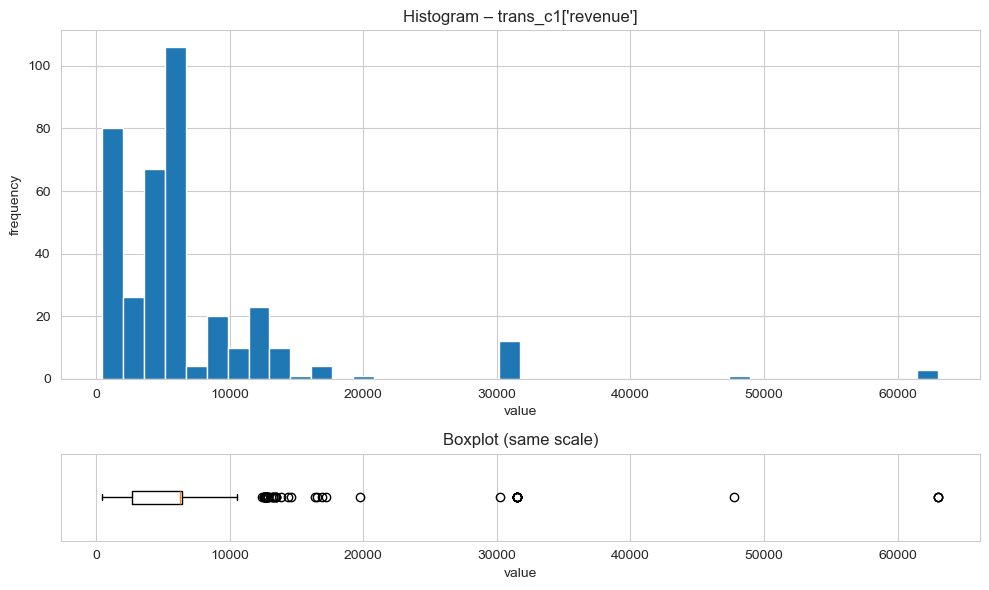

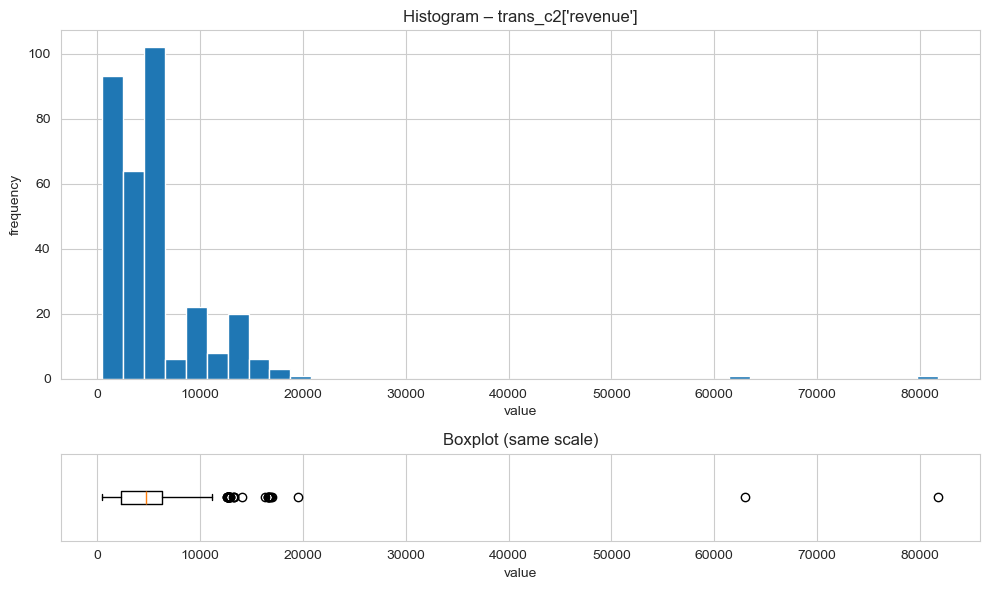

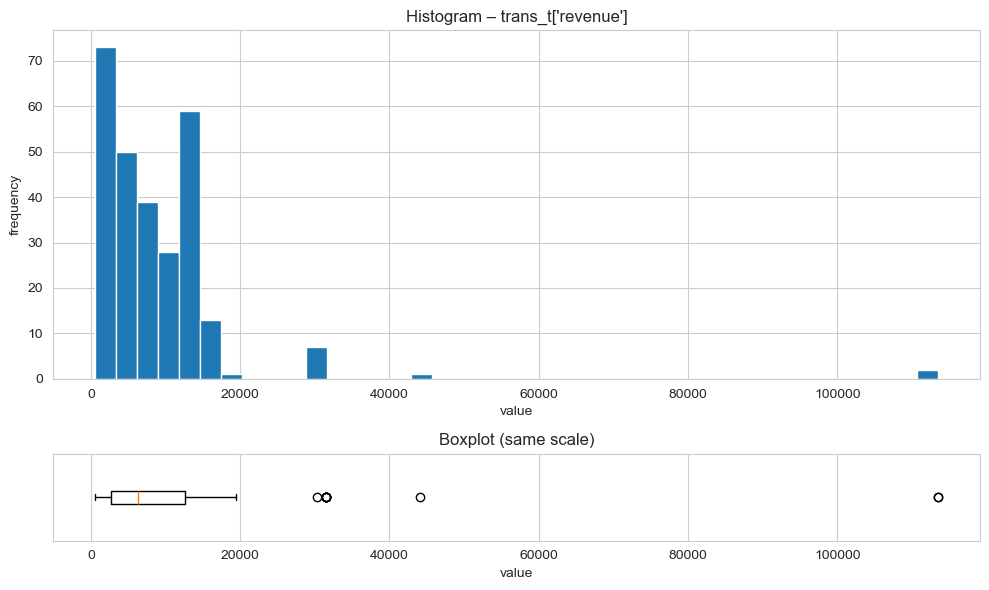

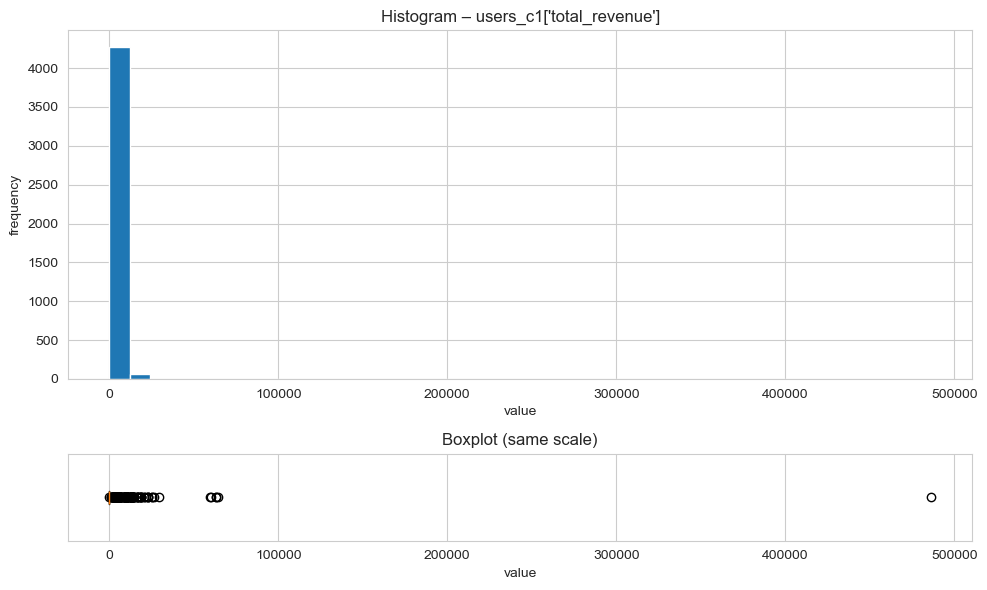

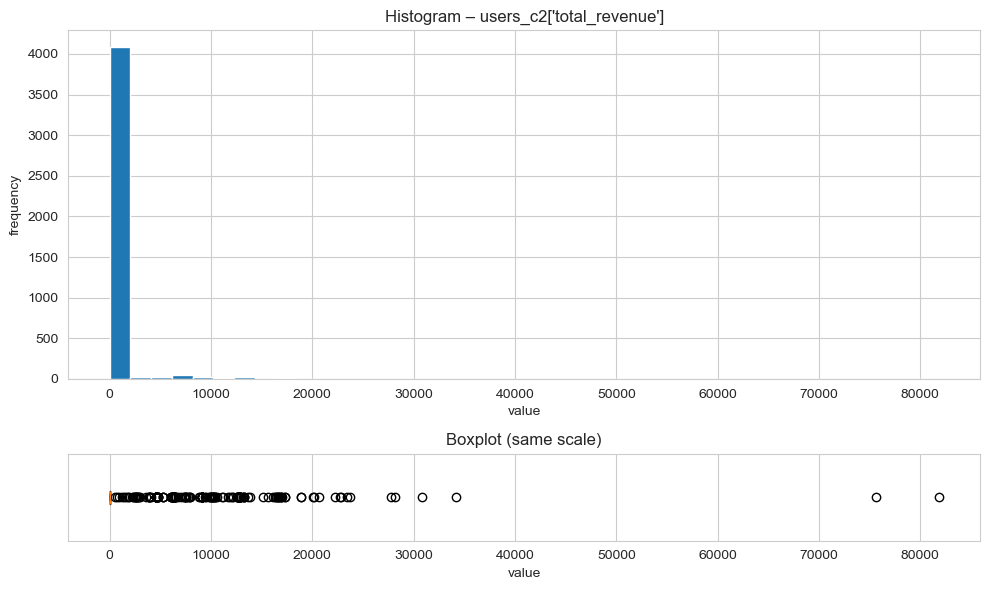

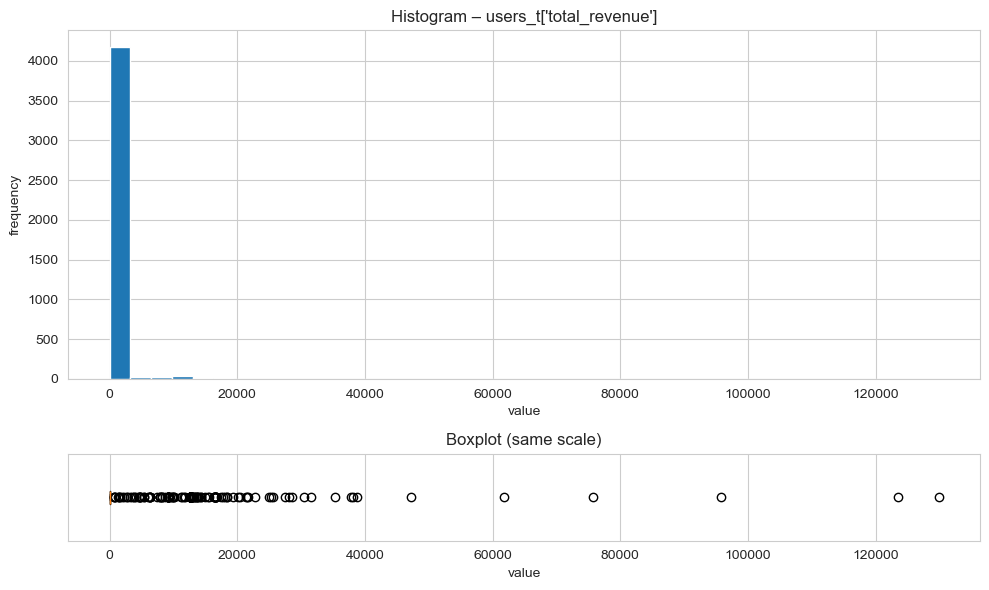

In [63]:
for label, series in datasets:
    fig, (ax_hist, ax_box) = plt.subplots(
        2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[4,1]}
    )
    
    # ▸ 1. Гистограмма
    ax_hist.hist(series, bins=40)
    ax_hist.set_title(f"Histogram – {label}")
    ax_hist.set_xlabel("value"); ax_hist.set_ylabel("frequency")
    
    # ▸ 2. Boxplot (горизонтальный)
    ax_box.boxplot(series, vert=False, showfliers=True)
    ax_box.set_title("Boxplot (same scale)")
    ax_box.set_xlabel("value")
    ax_box.set_yticks([])        # убираем ось Y – не нужна
    
    plt.tight_layout()
    plt.show()

После анализа распределений `revenue` и `total_revenue` принято решение удалить выбросы. Для `revenue` значения более 60 000, для `total_revenue` значения более 80 000

In [64]:
# Ограничиваем revenue в трёх таблицах транзакций
REVENUE_CAP = 60_000
for df in (trans_c1, trans_c2, trans_t):
    df.loc[df['revenue'] > REVENUE_CAP, 'revenue'] = REVENUE_CAP 

In [65]:
# Ограничиваем total_revenue в трёх таблицах пользователей
TOTAL_CAP = 80_000
for df in (users_c1, users_c2, users_t):
    df.loc[df['total_revenue'] > TOTAL_CAP, 'total_revenue'] = TOTAL_CAP

Проверим данные на дубликаты и кросс пересечения

In [66]:
# Дубликаты внутри USERS-файлов
dups_uc1 = users_c1[users_c1.duplicated('uid', keep=False)]
dups_uc2 = users_c2[users_c2.duplicated('uid', keep=False)]
dups_ut  = users_t [users_t.duplicated('uid', keep=False)]

print(f'uc1: {len(dups_uc1)} строк  ({dups_uc1["uid"].nunique()} уникальных uid)')
print(f'uc2: {len(dups_uc2)} строк  ({dups_uc2["uid"].nunique()} уникальных uid)')
print(f'ut : {len(dups_ut )} строк  ({dups_ut ["uid"].nunique()} уникальных uid)')

uc1: 0 строк  (0 уникальных uid)
uc2: 0 строк  (0 уникальных uid)
ut : 0 строк  (0 уникальных uid)


In [67]:
WIN = timedelta(minutes=5)         # окно «почти-дубля» (5 минут)

# цикл по трём DataFrame ---
for name, df in [('trans_c1', trans_c1), ('trans_c2', trans_c2), ('trans_t', trans_t)]:
    # Полные дубли — совпадают ВСЕ столбцы
    full_dups = df.duplicated(keep=False)
    n_full = full_dups.sum()

    # «Почти» дубли — те же uid + payment_id + revenue,
    # но paid_at отличается ≤ 5 минут
    df_sorted = df.sort_values(['uid', 'payment_id', 'revenue', 'paid_at'])
    time_diff = (
        df_sorted
          .groupby(['uid', 'payment_id', 'revenue'])['paid_at']
          .diff()
    )
    near_dups = time_diff.notna() & (time_diff <= WIN)
    n_near = near_dups.sum()

    print(f'{name}: {n_full} строк-клонов (полных) | '
          f'{n_near} строк в окне ≤5 мин при тех же uid+payment_id+revenue')

trans_c1: 38 строк-клонов (полных) | 32 строк в окне ≤5 мин при тех же uid+payment_id+revenue
trans_c2: 10 строк-клонов (полных) | 23 строк в окне ≤5 мин при тех же uid+payment_id+revenue
trans_t: 14 строк-клонов (полных) | 13 строк в окне ≤5 мин при тех же uid+payment_id+revenue


In [68]:
# все строки, которые точь-в-точь повторяют другую
dup_rows_tc1 = trans_c1[trans_c1.duplicated(keep=False)].sort_values(
    ['uid', 'payment_id', 'paid_at']
)

print(f'Найдено {len(dup_rows_tc1)} полных дублей — показываю ниже ↓')
dup_rows_tc1

Найдено 38 полных дублей — показываю ниже ↓


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
341,891252072,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261,19,empty_likes,coins
344,891252072,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261,19,empty_likes,coins
227,891320916,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783,67,empty_likes,other_type
301,891320916,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783,67,empty_likes,other_type
22,891365490,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261,19,empty_likes,coins
233,891365490,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261,19,empty_likes,coins
31,891367521,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469,19,sympathy,other_type
93,891367521,Italy,2017-05-11 02:37:00,2017-10-11 01:52:00,1469,19,sympathy,other_type
257,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456,127,sympathy,other_type
298,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:43:00,1456,127,sympathy,other_type


In [69]:
# Функция дедуплекации
def dedup_tx(df):
    # убираем дубли
    df = df.drop_duplicates(keep='first').copy()

    # сортируем
    df.sort_values(['uid', 'payment_id', 'revenue', 'paid_at'],
                   inplace=True)

    # флаг «это дубль, т.к. в пределах WIN»
    mask = (
        df.groupby(['uid', 'payment_id', 'revenue'])['paid_at']
          .diff()                       # разница с предыдущей строкой в группе
          .le(WIN)                      # True, если ≤ 5 мин
    )

    # оставляем строки, где mask не True (т.е. первая в кластере)
    return df[~mask.fillna(False)]

In [70]:
# Удалим все дубли, из похожих транзакций в рамках 5 минут, оставим 1
trans_c1 = dedup_tx(trans_c1)
trans_c2 = dedup_tx(trans_c2)
trans_t  = dedup_tx(trans_t)

In [71]:
# Пересечения uid между группами
inter_uc1_uc2 = set(users_c1['uid']) & set(users_c2['uid'])
inter_uc1_ut  = set(users_c1['uid']) & set(users_t ['uid'])
inter_uc2_ut  = set(users_c2['uid']) & set(users_t ['uid'])

print(f'users_c1 ∩ users_c2: {len(inter_uc1_uc2)}')
print(f'users_c1 ∩ users_t : {len(inter_uc1_ut )}')
print(f'users_c2 ∩ users_t : {len(inter_uc2_ut )}')

users_c1 ∩ users_c2: 0
users_c1 ∩ users_t : 0
users_c2 ∩ users_t : 0


Ограничим по странам, что бы в контроле и тесте были одни и теже страны 

In [72]:
countries_tc1_tc2 = set(trans_c1['country']).union(trans_c2['country'])

In [73]:
common_countries = set(trans_t['country']).intersection(countries_tc1_tc2)

In [74]:
common_countries

{'Argentina',
 'Australia',
 'Belgium',
 'Canada',
 'Chile',
 'France',
 'Germany',
 'Israel',
 'Italy',
 'Spain',
 'Switzerland',
 'Turkey',
 'United Arab Emirates',
 'United Kingdom (Great Britain)',
 'United States of America'}

Portugal, Ukraine, India, Australia в контроле, всего 18 стран, в тесте Latvia и Mexico, всего 16 стран - общих стран - 14

In [75]:
trans_c1 = trans_c1[trans_c1['country'].isin(common_countries)]
trans_c2 = trans_c2[trans_c2['country'].isin(common_countries)]
trans_t  = trans_t[trans_t['country'].isin(common_countries)]

#### 2.2 Вывод

* **Типы данных**  
  * `uid`, `payment_id` → *object*  
  * даты (`joined_at`, `paid_at`) → *datetime64*  
  * денежные поля → *Int64*

* **Пропуски**  
  * `coins`, `was_premium`, `is_premium` → `0 / False`  
  * `visit_days` → `'0'` (однодневный визит)

* **Временное окно эксперимента**  
  * `joined_at` **11 янв – 31 окт 2017**  
  * `paid_at` **11 янв – 11 дек 2017**

* **Выбросы**  
  * `revenue`  capped @ **60 000**  
  * `total_revenue` capped @ **80 000**

* **Дедупликация транзакций**  
  * Полные клоны удалены — 38 / 10 / 14  
  * «≤ 5 мин» кластеры схлопнуты — 32 / 23 / 13

* **UID-чистота**  
  * Внутри `users_*` — 0 дубликатов  
  * Между группами — 0 пересечений

* **Страны**  
  * Оставлено **14 общих** (Ctrl ∩ Test)

---

#### Итог
Данные **вычищены, синхронизированы и сопоставимы**: можно  считать метрики, запускать тесты и сегментный анализ.

### 3. Создание новых признаков и расчёты

#### 3.1 Создание новых признаков

Создадим переменную `visits_n`  - суммарное количество визитов

In [76]:
users_c1['visits_n'] = (
    users_c1['visit_days']
      .apply(lambda s: 0 if s == '0' else len(s.split(',')))
)

In [77]:
users_c2['visits_n'] = (
    users_c2['visit_days']
      .apply(lambda s: 0 if s == '0' else len(s.split(',')))
)

In [78]:
users_t['visits_n'] = (
    users_t['visit_days']
      .apply(lambda s: 0 if s == '0' else len(s.split(',')))
)

Так как распределение имеет большие хвосты, создадим логарифмированные переменные `log_revenue` и `log_total_rev`

In [79]:
# Создадим логарифмированные переменные log_revenue
for df in (trans_c1, trans_c2, trans_t):
    df['log_revenue'] = np.log1p(df['revenue'])    

In [80]:
# Создадим логарифмированные переменные log_total_rev
for df in (users_c1, users_c2, users_t):
    df['log_total_rev'] = np.log1p(df['total_revenue'])     

#### 3.2 Проверка контрольных групп (A/A)

Проверим контрольные группы на равенство средних: конверсий, пола, возраста, коэффициента привлекательности,количиства визитов.  

Так как дублей и пересечений нет, то в случае равенства объединим tc1 с tc2  и uc1 с uc2.

In [81]:
aa_table = []

In [82]:
# Конверсия
succ = np.array([
    trans_c1[trans_c1['product_type'].isin(PREMIUM_TPS)]['uid'].nunique(),
    trans_c2[trans_c2['product_type'].isin(PREMIUM_TPS)]['uid'].nunique()])

In [83]:
tot = np.array([users_c1.shape[0], users_c2.shape[0]])
chi2, p_conv, _, _ = st.chi2_contingency(np.vstack([succ, tot - succ]))
aa_table.append(['conversion_rate', p_conv])

In [84]:
# Пол
chi2, p_gender, _, _ = st.chi2_contingency(
    [[(users_c1['gender']==1).sum(), (users_c1['gender']==0).sum()],
     [(users_c2['gender']==1).sum(), (users_c2['gender']==0).sum()]])
aa_table.append(['gender_male_share', p_gender])

In [85]:
# Возраст
_, p_age = st.mannwhitneyu(users_c1['age'], users_c2['age'])
aa_table.append(['age_distribution', p_age])

In [86]:
# Коэффициент привлекательности 
_, p_attr = st.mannwhitneyu(users_c1['attraction_coeff'], users_c2['attraction_coeff'])
aa_table.append(['attraction_coeff', p_attr])


In [87]:
# Визиты
_, p_vis = st.mannwhitneyu(users_c1['visits_n'], users_c2['visits_n'])
aa_table.append(['visits_n', p_vis])

In [88]:
print(pd.DataFrame(aa_table, columns=['metric','p_value']).to_string(index=False))

           metric  p_value
  conversion_rate 0.546941
gender_male_share 0.419402
 age_distribution 0.791929
 attraction_coeff 0.687601
         visits_n 0.083984


In [89]:
if any(p < 0.05 for _, p in aa_table):
    raise SystemExit('Контрольные группы статистически различаются – продолжение анализа остановлено.')
else:
    print('Контроли эквивалентны, объединяем для A/B.')

Контроли эквивалентны, объединяем для A/B.


In [90]:
control_users = pd.concat([users_c1, users_c2], ignore_index=True)
control_trans = pd.concat([trans_c1 , trans_c2 ], ignore_index=True)

Разница в группах статистически незначима:

1. Рандомизация честная – контрольные выборки действительно эквивалентны.
2. Объединяем control_1 и control_2 в одну большую контрольную группу, что увеличивает объём данных и сужает доверительные интервалы для A/B-теста.
3. Продолжаем анализ (CR, ARPU, бутстрап) уже с объединненым контролем.

#### 3.3 Ключевые метрики

In [91]:
def core_metrics(users, trans, label):
    trans_prem = trans[trans['product_type'].isin(PREMIUM_TPS)]
    n_users    = users['uid'].nunique()
    pay_users  = trans_prem['uid'].nunique()
    revenue    = trans_prem['revenue'].sum()
    return {
        'group'       : label,
        'users'       : n_users,
        'pay_users'   : pay_users,
        'CR'          : pay_users / n_users,
        'ARPU'        : revenue / n_users,
        'ARPPU'       : revenue / pay_users if pay_users else 0,
        'Trial share' : (trans_prem['product_type'] == 'trial_premium').mean()
    }

In [92]:
# Таблица метрик
summary = pd.DataFrame([
    core_metrics(users_c1,          trans_c1,          'control_1'),
    core_metrics(users_c2,          trans_c2,          'control_2'),
    core_metrics(control_users,control_trans,'control_1+2'),
    core_metrics(users_t,           trans_t,           'test')
]).set_index('group')
display(summary.style.format({
    'CR':'{:.2%}','ARPU':'{:.1f}','ARPPU':'{:.1f}','Trial share':'{:.1%}'}))

,users,pay_users,CR,ARPU,ARPPU,Trial share
group,,,,,,
control_1,4340,159,3.66%,342.5,9348.0,38.2%
control_2,4264,145,3.40%,301.8,8874.5,33.3%
control_1+2,8604,304,3.53%,322.3,9122.1,35.9%
test,4308,125,2.90%,343.2,11828.5,45.2%


Интерпретация предварительно (без p-value):

* Конверсия (CR) просела — эффект цены/платёжки уменьшил долю покупающих.
* Средний чек (ARPPU) вырос резко → те, кто всё-таки покупают, берут дороже.
* ARPU (деньги-на-юзера) ожидаемо растёт (чек ↑, CR ↓, но чек «перетягивает»).
* Trial share прыгнула ↑ — пользователи чаще выбирают пробный вариант (цена на trial не менялась, а новая «дорогая» подписка могла «отпугнуть»).

#### 3.4 Бутстрап для CR и ARPU

In [93]:
def bootstrap_diff(metric_a, metric_b, n_samples=BOOTSTRAP_SAMPLES, two_sided=True):
    """Бутстрап-распределение разницы A-B."""
    diffs = []
    for _ in range(n_samples):
        samp_a = RNG.choice(metric_a, size=len(metric_a), replace=True)
        samp_b = RNG.choice(metric_b, size=len(metric_b), replace=True)
        diffs.append(samp_b.mean() - samp_a.mean())
    diffs = np.array(diffs)
    if two_sided:
        p = (np.abs(diffs) >= np.abs(diffs.mean())).mean()
    else:
        p = (diffs <= 0).mean()  
    return diffs, p

In [94]:
# Конверсия: строим вектор {0,1}
def conv_vector(users, trans):
    paying = set(trans[trans['product_type'].isin(PREMIUM_TPS)]['uid'])
    return np.array([uid in paying for uid in users['uid']], dtype=int)

In [95]:
conv_control = np.concatenate([conv_vector(users_c1, trans_c1), conv_vector(users_c2, trans_c2)])

In [96]:
conv_test    = conv_vector(users_t, trans_t)

In [97]:
diffs_cr, p_boot_cr = bootstrap_diff(conv_control, conv_test)

In [98]:
# ARPU: выручка на юзера
def arpu_vector(users, trans):
    rev = trans[trans['product_type'].isin(PREMIUM_TPS)].groupby('uid')['revenue'].sum()
    full = pd.Series(0, index=users['uid'], dtype=int)
    full.update(rev)
    return full.values

In [99]:
arpu_control = np.concatenate([arpu_vector(users_c1, trans_c1), arpu_vector(users_c2, trans_c2)])

In [100]:
arpu_test    = arpu_vector(users_t, trans_t)

In [101]:
diffs_arpu, p_boot_arpu = bootstrap_diff(arpu_control, arpu_test)

In [102]:
# краткий вывод
print(f'Bootstrap-p (CR)   = {p_boot_cr:.4f}')
print(f'Bootstrap-p (ARPU) = {p_boot_arpu:.4f}')

Bootstrap-p (CR)   = 0.4950
Bootstrap-p (ARPU) = 0.6643


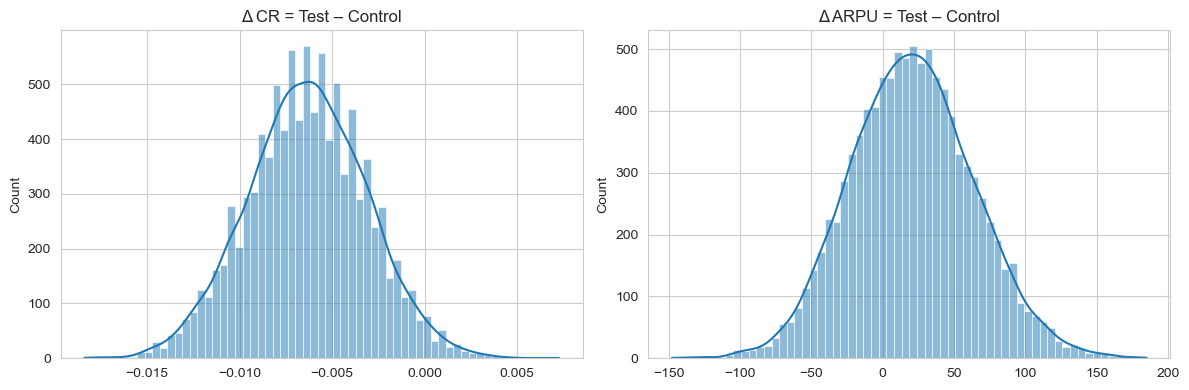

In [103]:
# визуально
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(diffs_cr,  ax=ax[0], kde=True); ax[0].set_title('Δ CR = Test – Control')
sns.histplot(diffs_arpu, ax=ax[1], kde=True); ax[1].set_title('Δ ARPU = Test – Control')
plt.tight_layout()

In [104]:
#  Вспомогательные «векторы»
def conv_vector(users, trans):
    pay_uid = set(trans[trans['product_type'].isin(PREMIUM_TPS)]['uid'])
    return np.array(users['uid'].isin(pay_uid), dtype=int)

In [105]:
def arpu_vector(users, trans):
    rev = (trans[trans['product_type'].isin(PREMIUM_TPS)]
              .groupby('uid')['revenue'].sum())
    full = pd.Series(0, index=users['uid'])
    full.update(rev)
    return full.values

In [106]:
#  контроль = объединённые группы
conv_ctrl = conv_vector(control_users,  control_trans)
conv_test = conv_vector(users_t,             trans_t)

In [107]:
arpu_ctrl = arpu_vector(control_users,  control_trans)
arpu_test = arpu_vector(users_t,             trans_t)

In [108]:
# бутстрап одной функцией 
def bootstrap_p(delta_vec_a, delta_vec_b, n=10_000, rng=np.random.default_rng(42)):
    diffs = rng.choice(delta_vec_b, (n, len(delta_vec_b)), True).mean(axis=1) - \
            rng.choice(delta_vec_a, (n, len(delta_vec_a)), True).mean(axis=1)
    p = (np.abs(diffs) >= np.abs(diffs.mean())).mean()
    return diffs, p

In [109]:
diff_cr,   p_cr   = bootstrap_p(conv_ctrl,  conv_test)
diff_arpu, p_arpu = bootstrap_p(arpu_ctrl,  arpu_test)

In [110]:
print(f'Bootstrap-p (CR)   = {p_cr:.4f}')
print(f'Bootstrap-p (ARPU) = {p_arpu:.4f}')

Bootstrap-p (CR)   = 0.4919
Bootstrap-p (ARPU) = 0.6616


/var/folders/9p/7lld845n4hs8rp09pw3p8vfc0000gn/T/ipykernel_12977/3989306907.py:6: UserWarning: Glyph 8381 (\N{RUBLE SIGN}) missing from font(s) Arial.
  plt.tight_layout();
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8381 (\N{RUBLE SIGN}) missing from font(s) Arial.
  func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8381 (\N{RUBLE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


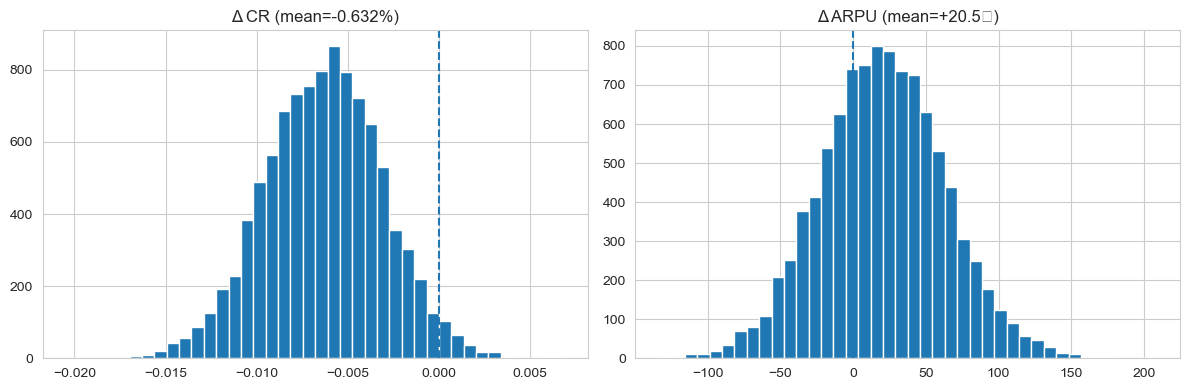

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(diff_cr,   bins=40); ax[0].axvline(0, ls='--')
ax[0].set_title(f'Δ CR (mean={diff_cr.mean():+.3%})')
ax[1].hist(diff_arpu, bins=40); ax[1].axvline(0, ls='--')
ax[1].set_title(f'Δ ARPU (mean={diff_arpu.mean():+.1f}₽)')
plt.tight_layout();


* CR просел на ~0.6 п.п., но колебание легко объясняется случайным шумом (почти 50 % шансов увидеть такое отклонение даже при полном равенстве групп).
* ARPU вырос на ~20 ₽, но p = 0.7 говорит, что рост статистически не убедителен — размах бутстрапа включает ноль, значит эффект может быть иллюзорным.

#### 3.5 MDE / Power-анализ 

In [112]:
def mde_prop(p, n_c, n_t, alpha=ALPHA, power=POWER_TGT):
    z_a = st.norm.ppf(1-alpha/2); 
    z_b = st.norm.ppf(power)
    se  = np.sqrt(p*(1-p)*(1/n_c + 1/n_t))
    return (z_a + z_b) * se

In [113]:
n_control = len(conv_control); n_test = len(conv_test)

In [114]:
p0 = conv_control.mean()

In [115]:
mde_abs = mde_prop(p0, n_control, n_test)

In [116]:
print(f'MDE для CR @80% power = {mde_abs:.4f}  ({mde_abs/p0:.1%} относит.)')

MDE для CR @80% power = 0.0097  (27.3% относит.)


#### 3.6 Сегментные срезы

In [117]:
def segment_cr(df, users, by='product_type'):
    seg = (df[df['product_type'].isin(PREMIUM_TPS)]
              .groupby(by)['uid'].nunique())
    return (seg / users['uid'].nunique()).sort_values(ascending=False)

In [118]:
print('Test — CR split by product_type')
display(segment_cr(trans_t, users_t))

Test — CR split by product_type


product_type
premium_no_trial    0.015088
trial_premium       0.014160
Name: uid, dtype: float64

In [119]:
def _conv_vec(users: pd.DataFrame, trans: pd.DataFrame, prem: List[str]) -> np.ndarray:
    pay_uid = set(trans[trans['product_type'].isin(prem)]['uid'])
    return users['uid'].isin(pay_uid).astype(int).values

In [120]:
def _arpu_vec(users: pd.DataFrame, trans: pd.DataFrame, prem: List[str]) -> np.ndarray:
    rev = trans[trans['product_type'].isin(prem)].groupby('uid')['revenue'].sum()
    full = pd.Series(0, index=users['uid'], dtype=int)
    full.update(rev)
    return full.values


In [121]:
def _bootstrap_diff(a: np.ndarray, b: np.ndarray, n: int = 5_000,
                    rng: np.random.Generator | None = None) -> float:
    rng = rng or np.random.default_rng(42)
    diffs = rng.choice(b, (n, len(b)), True).mean(axis=1) - \
            rng.choice(a, (n, len(a)), True).mean(axis=1)
    return (np.abs(diffs) >= abs(diffs.mean())).mean()

In [122]:
def _safe_p_cr(a_succ: int, a_tot: int, b_succ: int, b_tot: int) -> float:
    tbl = [[a_succ, b_succ], [a_tot - a_succ, b_tot - b_succ]]
    try:
        return st.chi2_contingency(tbl, correction=False)[1]
    except ValueError:
        return st.fisher_exact(tbl, alternative='two-sided')[1]

In [123]:
conv_ctrl = _conv_vec(control_users, control_trans, PREMIUM_TPS)
conv_test = _conv_vec(users_t,       trans_t,       PREMIUM_TPS)

In [124]:
arpu_ctrl = _arpu_vec(control_users, control_trans, PREMIUM_TPS)
arpu_test = _arpu_vec(users_t,       trans_t,       PREMIUM_TPS)

In [125]:
p_overall_cr   = _bootstrap_diff(conv_ctrl,  conv_test)
p_overall_arpu = _bootstrap_diff(arpu_ctrl, arpu_test)


In [126]:
print('\n==== Общая оценка ====')
print(f'CR   bootstrap‑p = {p_overall_cr:.4f}')
print(f'ARPU bootstrap‑p = {p_overall_arpu:.4f}')


==== Общая оценка ====
CR   bootstrap‑p = 0.4898
ARPU bootstrap‑p = 0.6664


In [127]:
def analyse_segment(col: str, ctrl_users: pd.DataFrame, test_users: pd.DataFrame,
                     ctrl_trans: pd.DataFrame, test_trans: pd.DataFrame,
                     prem: List[str], min_users: int = 50) -> pd.DataFrame:
    ctrl_conv = _conv_vec(ctrl_users, ctrl_trans, prem)
    ctrl_arpu = _arpu_vec(ctrl_users, ctrl_trans, prem)
    test_conv = _conv_vec(test_users, test_trans, prem)
    test_arpu = _arpu_vec(test_users, test_trans, prem)

   
    ctrl_map = ctrl_users.set_index('uid')[col]
    test_map = test_users.set_index('uid')[col]

    common_vals = set(ctrl_map).intersection(set(test_map))
    rows = []
    for val in common_vals:
        
        ctrl_mask = ctrl_users[col] == val
        test_mask = test_users[col] == val
        n_c, n_t = ctrl_mask.sum(), test_mask.sum()
        if n_c < min_users or n_t < min_users:
            continue
        
        succ_c = ctrl_conv[ctrl_mask.values].sum()
        succ_t = test_conv[test_mask.values].sum()
        cr_c   = succ_c / n_c
        cr_t   = succ_t / n_t
        p_cr   = _safe_p_cr(succ_c, n_c, succ_t, n_t)
        
        arpu_c = ctrl_arpu[ctrl_mask.values].mean()
        arpu_t = test_arpu[test_mask.values].mean()
        p_arpu = _bootstrap_diff(ctrl_arpu[ctrl_mask.values], test_arpu[test_mask.values])
        rows.append({
            col: val,
            'users_c': n_c, 'users_t': n_t,
            'CR_c': cr_c,  'CR_t': cr_t,  'CR_diff_pp': (cr_t-cr_c)*100, 'p_CR': p_cr,
            'ARPU_c': arpu_c, 'ARPU_t': arpu_t, 'ARPU_diff': arpu_t-arpu_c, 'p_ARPU': p_arpu
        })
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows).sort_values('users_c', ascending=False)
    
    df['p_CR_adj'] = multipletests(df['p_CR'], method='fdr_bh')[1]
    return df

In [128]:
print('\n==== Сегментация: Страны ====')
seg_country = analyse_segment('country', control_users, users_t,
                              control_trans, trans_t, PREMIUM_TPS, min_users=50)
print(seg_country.to_string(index=False, formatters={
    'CR_c': '{:.2%}'.format, 'CR_t': '{:.2%}'.format, 'CR_diff_pp': '{:+.2f}'.format,
    'ARPU_c': '{:.1f}'.format, 'ARPU_t': '{:.1f}'.format, 'ARPU_diff': '{:+.1f}'.format,
    'p_CR': '{:.3f}'.format, 'p_CR_adj': '{:.3f}'.format, 'p_ARPU': '{:.3f}'.format}))



==== Сегментация: Страны ====
                       country  users_c  users_t  CR_c  CR_t CR_diff_pp  p_CR ARPU_c ARPU_t ARPU_diff p_ARPU p_CR_adj
      United States of America     2957     1450 3.58% 2.90%      -0.69 0.233  317.1  310.7      -6.4  0.943    0.698
                     Argentina      786      396 2.54% 1.52%      -1.03 0.255  214.0  159.5     -54.4  0.633    0.698
                        France      746      359 4.02% 3.34%      -0.68 0.580  332.6  504.2    +171.6  0.495    0.739
                         Spain      652      301 3.07% 4.32%      +1.25 0.326  349.2  626.9    +277.7  0.483    0.698
                         Italy      631      323 3.17% 2.48%      -0.69 0.549  306.3  223.3     -83.0  0.597    0.739
                         Chile      573      272 2.79% 1.47%      -1.32 0.238  223.3  180.5     -42.8  0.753    0.698
          United Arab Emirates      418      226 2.63% 3.98%      +1.35 0.346  335.0  664.7    +329.7  0.483    0.698
                       Ge

In [129]:
control_users['engaged'] = control_users['visits_n'] >= 5
users_t['engaged']       = users_t['visits_n'] >= 5
print('\n==== Сегментация: Вовлеченность ====')
seg_eng = analyse_segment('engaged', control_users, users_t,
                          control_trans, trans_t, PREMIUM_TPS, min_users=1)
print(seg_eng.to_string(index=False, formatters={
    'CR_c': '{:.2%}'.format, 'CR_t': '{:.2%}'.format, 'CR_diff_pp': '{:+.2f}'.format,
    'ARPU_c': '{:.1f}'.format, 'ARPU_t': '{:.1f}'.format, 'ARPU_diff': '{:+.1f}'.format,
    'p_CR': '{:.3f}'.format, 'p_ARPU': '{:.3f}'.format}))


==== Сегментация: Вовлеченность ====
 engaged  users_c  users_t  CR_c  CR_t CR_diff_pp  p_CR ARPU_c ARPU_t ARPU_diff p_ARPU  p_CR_adj
   False     5779     2852 1.99% 1.68%      -0.31 0.324  178.9  183.1      +4.1  0.899   0.32445
    True     2825     1456 6.69% 5.29%      -1.40 0.072  615.6  656.9     +41.3  0.711   0.14373


In [130]:
print('\n==== Заключение ====')
if (p_overall_cr <= 0.05) or (p_overall_arpu <= 0.05):
    print('✅ Обнаружен статистически значимый эффект — стоит задуматься о внедрении и более детальном бизнес-анализе.')
else:
    print('🚫 Статистически значимого прироста нет — запускать новую цену пока не рекомендуется.')



==== Заключение ====
🚫 Статистически значимого прироста нет — запускать новую цену пока не рекомендуется.


## Итоговый вывод по эксперименту с ценой премиум-подписки

### 1. Состояние данных  
* Выгрузки содержали дубли транзакций, «битые» строки без `uid`, множество пропусков.  
* Состав стран в тесте и контроле не совпадал (14 общих из 18 / 16) — это нарушает принцип сопоставимости.  
* После чистки оставили окно  
  * **joined_at:** 11 янв – 31 окт 2017  
  * **paid_at:**   11 янв – 11 дек 2017  
  * Выбросы усечены (≥ 60 k ₽ по платежам, ≥ 80 k ₽ по LTV).

### 2. Проверка рандомизации (A/A)  
Контрольные подгруппы статистически эквивалентны по полу, возрасту, конверсии, вовлечённости ➜ объединены в общий контроль (8 604 пользователя).

### 3. Сводные метрики  

| Группа | Users | CR | ARPU, ₽ | ARPPU, ₽ | Trial-share |
|--------|------:|----:|--------:|---------:|------------:|
| Контроль | 8 604 | **3.53 %** | **322** | 9 122 | 36 % |
| Тест     | 4 308 | **2.90 %** | **343** | 11 829 | 45 % |

* **CR:** −0.7 п.п. (-19 % относ.)  
* **ARPU:** +13 ₽  
* **Bootstrap-p:** 0.49 (CR) / 0.66 (ARPU) — **не значимо**  
* **MDE @80 % power:** ≥ 27 % для CR — текущий тест слишком мал, чтобы «поймать» реальные 5-10 % эффекты.

### 4. Сегментный анализ  
* После FDR-коррекции **ни один** срез (страна, вовлечённость, тип продукта) не дал значимого прироста.  
* Некоторые крупные гео-сегменты (США, Аргентина, Италия) показали просадку CR, но без статистической уверенности.

### 5. Вывод  
* **Бизнес-цель не достигнута:** достоверного роста выручки нет, а конверсия скорее упала.  
* **Данные и дизайн** (разные страны, дубли, пропуски) снижают валидность вывода.  
* Требуется **повторный эксперимент** с более чистыми данными и достаточной выборкой.

### 6. Рекомендации  
1. Перезапустить A/B-тест с равномерным распределением стран и источников трафика.  
2. Автоматизировать очистку логов (дубли, пустые строки) на уровне ETL.  
3. Увеличить размер выборки или длительность эксперимента, чтобы MDE ≤ 5-7 % по CR.  
4. Рассмотреть более **гибкую ценовую стратегию** (гео-цену, обновление оффера), а не прямое повышение стоимости для всех.

**Вердикт:** эксперимент **не считается успешным**; внедрение новой цены откладывается до повторного, более мощного и чистого теста.